Import neccessary libraries

In [35]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

Data Acquistion and Loading

In [36]:
# We will download historical stock data for Toyota Motor corp (TM)
try:
    # Download data from 2010 to the end of 2023
    data = yf.download("TM",start="2010-01-01",end="2023-12-31")

    # Check if data is empty
    if data.empty:
        print("No data downloaded. Check ticker symbol or date range")
    else:
        print(f"Successfully downloaded {len(data)} rows of data")
except Exception as e:
    print(f"Error downloading data: {e}")
    # Exit or handle error appropriately

C:\Users\Dell\AppData\Local\Temp\ipykernel_5372\3760516388.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("TM",start="2010-01-01",end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

Successfully downloaded 3522 rows of data


In [37]:
data

Price,Close,High,Low,Open,Volume
Ticker,TM,TM,TM,TM,TM
Date,,,,,
2010-01-04,57.091179,57.151569,56.842896,56.869738,258800
2010-01-05,56.212124,56.299361,55.702145,55.809507,466000
2010-01-06,56.930134,57.084473,56.500675,56.601331,390000
2010-01-07,56.225525,56.259073,55.769225,55.769225,377700
2010-01-08,57.547462,57.634694,56.701964,56.701964,351900
...,...,...,...,...,...
2023-12-22,170.646301,171.324955,170.139707,170.197055,322800
2023-12-26,171.908020,172.405047,170.646303,170.646303,198500


In [38]:
# Create a copy to avoid SettingsWithCopyWarning
df = data.copy()

Feature Engineering

In [39]:
# This is the most creative part. We create new features (signals) from the existing 
# data that the model can use to find patterns

print("Starting Feature Engineering.............")

# Feature 1: Lagged Features
# We assume the price N days ago affects today's price
# We will use lags of the "Close"price
lag_periods = [1,5,10] # 1 day, 1 week (5 trading days), 2 weeks
for lag in lag_periods:
    df[f"lag_{lag}"] = df["Close"].shift(lag)

Starting Feature Engineering.............


In [40]:
# Feature 2: Moving Averages (SMA)
# These smooth out short-term price fluctuatons and highlight longer-term trends
ma_windows = [10,30,60] # Short, medium and long-term windows
for window in ma_windows:
    df[f"sma_{window}"] = df["Close"].rolling(window=window).mean()

In [41]:
# Feature 3: Rolling Volatility (Standard Deviation)
# This measures price volatility. High volatility might be a predictive signal
for window in ma_windows:
    df[f"volatility_{window}"] = df["Close"].rolling(window=window).std()

In [42]:
# Feature 4: Price Change (Momentum)
# The difference in price from the previous day
df["price_change_1"] = df['Close'].diff(1)

In [43]:
# Feature 5: Date-based Features
# The model may find patterns in the day of the week, month, etc
df["day_of_week"] = df.index.dayofweek # 0 = monday, 6 = Sunday
df["month"] = df.index.month
df["quarter"] = df.index.quarter
df["year"] = df.index.year

print("Feature Engineering complete....")

Feature Engineering complete....


In [44]:
df

Price,Close,High,Low,Open,Volume,lag_1,lag_5,lag_10,sma_10,sma_30,sma_60,volatility_10,volatility_30,volatility_60,price_change_1,day_of_week,month,quarter,year
Ticker,TM,TM,TM,TM,TM,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,
2010-01-04,57.091179,57.151569,56.842896,56.869738,258800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,2010
2010-01-05,56.212124,56.299361,55.702145,55.809507,466000,57.091179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.879055,1,1,1,2010
2010-01-06,56.930134,57.084473,56.500675,56.601331,390000,56.212124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.718010,2,1,1,2010
2010-01-07,56.225525,56.259073,55.769225,55.769225,377700,56.930134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.704609,3,1,1,2010
2010-01-08,57.547462,57.634694,56.701964,56.701964,351900,56.225525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.321938,4,1,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,170.646301,171.324955,170.139707,170.197055,322800,172.873413,172.644012,179.009933,174.723929,178.412204,174.283607,2.595609,3.610314,6.230959,-2.227112,4,12,4,2023
2023-12-26,171.908020,172.405047,170.646303,170.646303,198500,170.646301,175.186569,178.818756,174.032855,178.184395,174.285200,2.285719,3.799434,6.230329,1.261719,1,12,4,2023


In [45]:
df.dropna(inplace=True)

In [46]:
df

Price,Close,High,Low,Open,Volume,lag_1,lag_5,lag_10,sma_10,sma_30,sma_60,volatility_10,volatility_30,volatility_60,price_change_1,day_of_week,month,quarter,year
Ticker,TM,TM,TM,TM,TM,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,
2010-03-30,55.001087,55.285399,54.858931,54.933395,707700,54.818321,55.259262,53.299850,54.168097,51.792249,53.510878,0.833493,2.093747,3.794550,0.182766,1,3,1,2010
2010-03-31,54.439243,54.703248,54.337702,54.649097,839400,55.001087,54.742565,53.212620,54.290759,51.948330,53.466679,0.764673,2.111236,3.767488,-0.561844,2,3,1,2010
2010-04-01,54.486610,54.933391,53.985679,54.100757,1513000,54.439243,53.903767,52.883816,54.451038,52.121871,53.437921,0.583524,2.098305,3.752733,0.047367,3,4,2,2010
2010-04-05,55.007866,55.271871,53.843534,54.831861,2937700,54.486610,54.662621,53.387081,54.613117,52.314800,53.405883,0.469025,2.088352,3.730554,0.521255,0,4,2,2010
2010-04-06,54.723537,55.095855,54.527230,54.770928,1190600,55.007866,54.818321,53.809826,54.704488,52.507646,53.380850,0.374654,2.032153,3.716324,-0.284328,1,4,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,170.646301,171.324955,170.139707,170.197055,322800,172.873413,172.644012,179.009933,174.723929,178.412204,174.283607,2.595609,3.610314,6.230959,-2.227112,4,12,4,2023
2023-12-26,171.908020,172.405047,170.646303,170.646303,198500,170.646301,175.186569,178.818756,174.032855,178.184395,174.285200,2.285719,3.799434,6.230329,1.261719,1,12,4,2023


Pre-Training Visualization

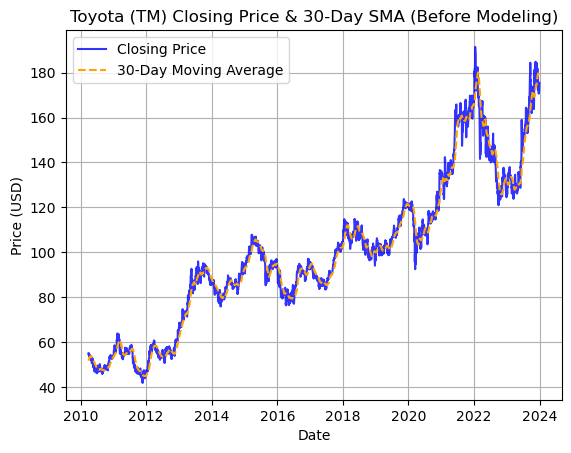

In [47]:
# Let's visualize the raw closing price and one of our engineered features
plt.Figure(figsize=(14,7))
plt.title("Toyota (TM) Closing Price & 30-Day SMA (Before Modeling)")
plt.plot(df["Close"],label="Closing Price",color="blue",alpha=0.8)
plt.plot(df["sma_30"],label="30-Day Moving Average",color="orange",linestyle="--")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

Data Preprocessing and Target Definition

In [48]:
# Define the Target Variable (y)
# We want to predict the "next day's " "Close" price
# shift(-1) moves tomorrow's price into today's row
df['Target'] = df["Close"].shift(-1)

In [49]:
# Handle NaNs
# Our feature engineering (lags,MAs) and target shifting created NaNs
# We must drop all rows with any NaN values a clean dataset
# The initial NaNs is from the "target" shift (last row has no "next day")
print(f"Rows before dropping NaNs: {len(df)}")

df_clean = df.dropna()

print(f"Rows after dropping NaNs: {len(df_clean)}")

# Define Feature Matrix (X) and Target Vector (y)
# X contains all our predictive features
# y contains the value we want to predict (tomorrow's price)

Rows before dropping NaNs: 3463
Rows after dropping NaNs: 3462


In [50]:
# List all faeture columns we created 
# We exclude "Open","High","Low","Adj Close","Volume" for simplicity
# but they could also be used as features or have features engineered from them
features = [
    'lag_1', 'lag_5', 'lag_10',
    'sma_10', 'sma_30', 'sma_60',
    'volatility_10', 'volatility_30', 'volatility_60',
    'price_change_1',
    'day_of_week', 'month', 'quarter', 'year'
]

X = df_clean[features]
y = df_clean["Target"]

Data Splitting

In [51]:
# We cannot shuffle the data. We must split it sequentially
# The model must be trained on the past (train set) and
# tested on the future (test set)

test_size = 0.2 # Use 20% of the data for testing
split_index = int(len(X) * (1 - test_size))

X_train,X_test = X.iloc[:split_index],X.iloc[split_index:]
y_train,y_test = y.iloc[:split_index],y.iloc[split_index:]

print(f"Training set shape (X,y): {X_train.shape}, {y-y_train.shape}")
print(f"Testing set shape (X,y): {X_test.shape}, {y_test.shape}")

Training set shape (X,y): (2769, 14), Date
2010-03-30   -2714.560757
2010-03-31   -2714.513390
2010-04-01   -2713.992134
2010-04-05   -2714.276463
2010-04-06   -2714.899242
                 ...     
2023-12-21   -2598.353699
2023-12-22   -2597.091980
2023-12-26   -2596.260391
2023-12-27   -2595.887619
2023-12-28   -2593.717850
Name: Target, Length: 3462, dtype: float64
Testing set shape (X,y): (693, 14), (693,)


Data Scaling

In [52]:
# Many models (Linear Regression, SVR) perform poorly if features
# are on different scales (e.g., 'year' 2010-2023 vs 'price_change_1' -2 to 2).
# We scale the data to have a mean of 0 and a standard deviation of 1

# IMPORTANT: Fit the scaler ONLY on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

Model Training and Comparison

In [53]:
print("----- Starting Model Comaprsion -----")

# A dictionary to hold the models we want to compare
models = {
    "Linear Regression":LinearRegression(),
    "Lasso":Lasso(alpha=0.1,random_state=42),
    "Ridge":Ridge(alpha=1.0,random_state=42),
    "SVR (RBF Kernel)":SVR(kernel="rbf",C=1.0),
    "Decision Tree":DecisionTreeRegressor(max_depth=10,random_state=42),
    "Random Forest":RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
}

----- Starting Model Comaprsion -----


In [54]:
# A dictionary to store the evaluation results
results = {}

In [57]:
for name,model in models.items():
    print(f"Training {name}...........")

    # Train the model
    model.fit(X_train_scaled,y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    # We use multiple metrics for a complete picture

    # RMS (Root Mean Squared Error): Error in the same units as the target (USD)
    # Lower is better
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))

    # MAE (Mean Absolute Error): Avearge absolute error (USD)
    # Lower is better, less sensitive to large outliers than RMSE
    mae = mean_absolute_error(y_test,y_pred)

    # R-squared: Coefficient of determination
    # % of variance in y explained by X. 1.0 is perfect
    r2 = r2_score(y_test,y_pred)

    # Store results
    results[name] = {
        "RMSE":rmse,
        "MAE":mae,
        "R2":r2
    }


# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")

print("----- Initial Model Comparison Reults -----")
print(results_df)

Training Linear Regression...........
Training Lasso...........
Training Ridge...........
Training SVR (RBF Kernel)...........
Training Decision Tree...........
Training Random Forest...........
----- Initial Model Comparison Reults -----
                        RMSE        MAE        R2
Linear Regression   2.350218   1.751394  0.980332
Ridge               2.360308   1.763136  0.980162
Lasso               2.406225   1.808885  0.979383
Decision Tree      20.580454  15.951257 -0.508215
Random Forest      22.881509  17.847828 -0.864329
SVR (RBF Kernel)   49.903559  42.338714 -7.867809


Hyperparameter Tuning

In [62]:
# We will select the best model from our initial run (lowest RMSE)
# and try to improve it by tuning its hyperparameters

best_model_name = results_df.index[0]
best_model_instance = models[best_model_name]

print(f"----- Hyperparameter Tuning for {best_model_name} -----")

# Define parameter grids for the models we might tune
# We'l preare grids for the most likely winners
param_grids = {
    "Random Forest":{
        "n_estimators":[100,200],
        "max_depth":[10,20,None],
        "min_smaples_leaf":[2,4],
    },
    "SVR (RBF Kernel)":{
        "C":[1,10,100],
        "gamma":["scale",0.1]
    },
    "Decision Tree":{
        "max_depth":[5,10,20],
        "min_samples_split":[2,5],
        "min_samples_leaf":[1,2]
    },
    "Ridge":{
        "alpha":[0.1,1.0,10.0,100.0]
    },
    "Lasso":{
        'alpha': [0.01, 0.1, 1.0, 10.0]
    },
    "Linear Regression": {} # No parameters to tune
}



# Get the parameter grid for our best model
param_grid = param_grids.get(best_model_name,{})


if not param_grid:
    print(f"{best_model_name} has no parameters to tune in this script.")
    tuned_model = best_model_instance # It's already our best model
else:
    # Use TimeSeriesSplit for cross-validatioN. This is cruical
    # to respect the temporal order of the data
    tscv = TimeSeriesSplit(n_splits=5)

    # Setup GridSearchCv
    # We use "neg_mean_squared_error" because grid search maximizes a  score
    # so we use the negative of a "lowe is better" error metrics (MSE)

    grid_search = GridSearchCV(
        estimator=best_model_instance,
        param_grid=param_grid,
        cv=tscv,
        scoring="neg_mean_squared_error",
        n_jobs=-1, # Use all available CPU cores
        verbose=1 # Show progress
    )

    # Run the grid search
    grid_search.fit(X_train_scaled,y_train)

    # Get the best model from the search
    tuned_model = grid_search.best_estimator_


    print(f"Best parameters found: {grid_search.best_params_}")

----- Hyperparameter Tuning for Linear Regression -----
Linear Regression has no parameters to tune in this script.


Post-Training Visualization

Visualizing final model performance..........


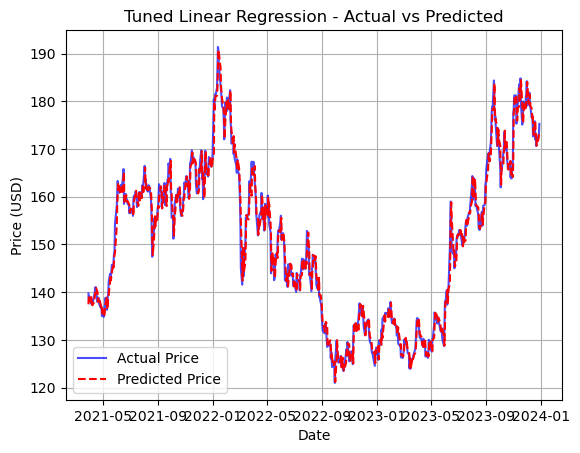

<Figure size 640x480 with 0 Axes>

In [69]:
# Let's see how our final, tuned model performed on the test set

print("Visualizing final model performance..........")
y_pred_tuned = tuned_model.predict(X_test_scaled)

plt.Figure(figsize=(14,7))
plt.title(f"Tuned {best_model_name} - Actual vs Predicted")
# We need to plot against the dates, so we use the y_test index
plt.plot(y_test.index,y_test,label="Actual Price",color="blue",alpha=0.7)
plt.plot(y_test.index,y_pred_tuned,label="Predicted Price",color="red",linestyle="--")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()
plt.savefig("pre_training_visualization.png")

In [65]:
# Final evaluation of the tuned model
tuned_rmse = np.sqrt(mean_squared_error(y_test,y_pred_tuned))
tuned_mae = mean_absolute_error(y_test,y_pred_tuned)
tuned_r2 = r2_score(y_test,y_pred_tuned)

print("----- Tuned Model Final Evaluation -----")
print(f'Tuned {best_model_name} RMSE: {tuned_rmse:.4f}')
print(f"Tuned {best_model_name} MAE: {tuned_mae:.4f}")
print(f"Tuned {best_model_name} R2: {tuned_r2:.4f}")

----- Tuned Model Final Evaluation -----
Tuned Linear Regression RMSE: 2.3502
Tuned Linear Regression MAE: 1.7514
Tuned Linear Regression R2: 0.9803


In [66]:
# Compare with original model's performance
original_metrics = results_df.loc[best_model_name]
print("----- Comparison with Original Model ----")
print(f"Original RMSE: {original_metrics["RMSE"]:.4f}")
print(f'Original MAE: {original_metrics["MAE"]:.4f}')
print(f"Original R2: {original_metrics["R2"]:.4f}")

----- Comparison with Original Model ----
Original RMSE: 2.3502
Original MAE: 1.7514
Original R2: 0.9803


Prediction Input

In [68]:
# To predict a new value, we need the *most recent* data,
# apply the *same* feature engineering, and use the *same* scaler.

print("\n--- Preparing for New Prediction ---")

# The last row of our *original* 'df' (before target shifting and dropna)
# contains the most recent data and features.
# We need to get the features from the *very last* row.
# Note: `df` was our copy of the downloaded data + feature engineering.
# The 'target' column for this row will be NaN, but the features will be valid.
last_row_features = df[features].iloc[-1]

print("Last available features (for predicting tomorrow):")
print(last_row_features)

# The scaler expects a 2D array.
# We reshape our 1D row of features into a 2D array with one sample.
last_row_scaled = scaler.transform(last_row_features.values.reshape(1, -1))

# Make the prediction
next_day_prediction = tuned_model.predict(last_row_scaled)

print("\n================================================")
print(f"Predicted 'Close' Price for the next day: ${next_day_prediction[0]:.2f}")
#print(f"Last actual 'Close' price was: ${df['Close'].iloc[-1]:.2f}")
print("================================================")


--- Preparing for New Prediction ---
Last available features (for predicting tomorrow):
Price           Ticker
lag_1                      173.112381
lag_5                      172.873413
lag_10                     175.320374
sma_10                     173.221347
sma_30                     177.428643
sma_60                     174.661961
volatility_10                1.681881
volatility_30                3.840608
volatility_60                5.897477
price_change_1               2.169769
day_of_week                  4.000000
month                       12.000000
quarter                      4.000000
year                      2023.000000
Name: 2023-12-29 00:00:00, dtype: float64

Predicted 'Close' Price for the next day: $175.15
